In [1]:
import gym
import numpy as np

import tensorflow as tf
import tensorflow.contrib.distributions as dist
import tensorflow.contrib.layers as layers

import matplotlib.pyplot as plt

/home/fyhsiao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

tf.set_random_seed(2019)
np.random.seed(2019)

<h2>Create Environments</h2>

In [3]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "Pendulum-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

<h2>Neural Network</h2>

In [4]:
class ActorCritic:
    def __init__(self, sess, obs, acs, hidden_size, name, trainable, init_std=1.0):
        self.sess = sess
        self.obs = obs
        self.acs = acs
        self.hidden_size = hidden_size
        self.name = name
        self.trainable = trainable
        self.init_std = init_std

        self.num_ac = self.acs.get_shape().as_list()[-1]

        with tf.variable_scope(name):
            self._build_network()

    def _build_network(self):
        with tf.variable_scope('critic'):
            c_h1 = layers.fully_connected(self.obs, self.hidden_size, trainable=self.trainable)
            c_out = layers.fully_connected(c_h1, 1, activation_fn=None, trainable=self.trainable)

        with tf.variable_scope('actor'):
            a_h1 = layers.fully_connected(self.obs, self.hidden_size, trainable=self.trainable)
            a_out = layers.fully_connected(a_h1, self.num_ac, activation_fn=None, trainable=self.trainable)

            log_std = tf.get_variable('log_std', [1, self.num_ac], dtype=tf.float32,
                                      initializer=tf.constant_initializer(self.init_std),
                                      trainable=self.trainable)

        std = tf.exp(log_std)
        a_dist = dist.Normal(a_out, std)
        self.log_prob = a_dist.log_prob(self.acs)
        self.entropy = tf.reduce_mean(a_dist.entropy())

        self.value = tf.identity(c_out)
        self.action = a_dist.sample()

    def params(self):
        return tf.global_variables(self.name).copy()

<h2>GAE</h2>

In [5]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h2>Proximal Policy Optimization Algorithm</h2>

In [6]:
class PPO:
    def __init__(self, sess, ob_shape, ac_shape, lr, hidden_size, eps=0.2, v_coeff=0.5, ent_coeff=0.01):
        self.sess = sess
        self.ob_shape = ob_shape
        self.ac_shape = ac_shape
        self.lr = lr
        self.hidden_size = hidden_size
        self.eps = eps
        self.v_coeff = v_coeff
        self.ent_coeff = ent_coeff

        self._create_ppo_graph()

    def _create_ppo_graph(self):
        self.obs = tf.placeholder(dtype=tf.float32, shape=[None] + self.ob_shape, name='observation')
        self.acs = tf.placeholder(dtype=tf.float32, shape=[None] + self.ac_shape, name='action')
        self.returns = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.advs = tf.placeholder(dtype=tf.float32, shape=[None, 1])

        self.pi = ActorCritic(self.sess, self.obs, self.acs, self.hidden_size, 'new_pi', trainable=True)
        self.old_pi = ActorCritic(self.sess, self.obs, self.acs, self.hidden_size, 'old_pi', trainable=False)

        self.pi_param = self.pi.params()
        self.old_pi_param = self.old_pi.params()

        with tf.name_scope('update_old_policy'):
            self.oldpi_update = [oldp.assign(p) for p, oldp in zip(self.pi_param, self.old_pi_param)]

        with tf.name_scope('loss'):
            ratio = tf.exp(self.pi.log_prob - self.old_pi.log_prob)
            surr = ratio * self.advs
            self.actor_loss = tf.reduce_mean(
                tf.minimum(surr, tf.clip_by_value(ratio, 1 - self.eps, 1 + self.eps) * self.advs))
            self.critic_loss = tf.reduce_mean(tf.square(self.returns - self.pi.value))

            self.loss = (- self.actor_loss - self.ent_coeff * tf.reduce_mean(self.pi.entropy)
                         + self.v_coeff * self.critic_loss)

        with tf.name_scope('train_op'):
            grads = tf.gradients(self.loss, self.pi_param)
            self.grads = list(zip(grads, self.pi_param))
            self.train_op = tf.train.AdamOptimizer(self.lr).apply_gradients(self.grads)

    def get_action(self, obs):
        return self.sess.run(self.pi.action, feed_dict={self.obs: obs})

    def get_value(self, obs):
        return self.sess.run(self.pi.value, feed_dict={self.obs: obs})

    def assign_old_pi(self):
        self.sess.run(self.oldpi_update)

    def update(self, obs, acs, returns, advs):
        feed_dict = {self.obs: obs,
                     self.acs: acs,
                     self.returns: returns,
                     self.advs: advs
                     }

        self.sess.run(self.train_op, feed_dict=feed_dict)

In [7]:
def ppo_iter(mini_batch_size, obs, acs, returns, advantage):
    batch_size = obs.shape[0]
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield (obs[rand_ids, :], acs[rand_ids, :],
               returns[rand_ids, :], advantage[rand_ids, :])

<h2>Testing Function</h2>

In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(model, vis=False):
    ob = env.reset()
    done = False
    total_reward = 0
    while not done:
        if vis:
            env.render()
        ac = model.get_action([ob])[0]
        next_ob, reward, done, _ = env.step(ac)
        ob = next_ob
        total_reward += reward
    return total_reward

<h2>Loading expert trajectories</h2>

In [9]:
try:
    expert_traj = np.load("expert_traj.npy")
except:
    print("Train, generate and save expert trajectories using ppo algorithm first")
    assert False

<h2>Generative Adversarial Imitation Learning</h2>

In [10]:
class Discriminator:
    def __init__(self, sess, ob_shape, ac_shape, hidden_size, lr, name):
        self.sess = sess
        self.ob_shape = ob_shape
        self.ac_shape = ac_shape
        self.hidden_size = hidden_size
        self.lr = lr
        self.name = name

        self.ob_ac = tf.placeholder(dtype=tf.float32, shape=[None, ob_shape[0] + ac_shape[0]])
        
        with tf.variable_scope(name):
            self._build_network()

    def _build_network(self):
        with tf.variable_scope('discriminator'):
            d_h1 = layers.fully_connected(self.ob_ac, self.hidden_size, activation_fn=tf.tanh)
            d_h2 = layers.fully_connected(d_h1, self.hidden_size, activation_fn=tf.tanh)
            d_out = layers.fully_connected(d_h2, 1, activation_fn=None)

        self.reward = - tf.squeeze(tf.log(tf.sigmoid(d_out)))
        
        expert_out, policy_out = tf.split(d_out, num_or_size_splits=2, axis=0)

        self.loss = (tf.losses.sigmoid_cross_entropy(tf.ones_like(policy_out), policy_out)
                     + tf.losses.sigmoid_cross_entropy(tf.zeros_like(expert_out), expert_out))
        
        with tf.name_scope('train_op'):
            grads = tf.gradients(self.loss, self.params())
            self.grads = list(zip(grads, self.params()))
            self.train_op = tf.train.AdamOptimizer(self.lr).apply_gradients(self.grads)

    def params(self):
        return tf.global_variables(self.name).copy()

    def get_reward(self, expert_ob_ac):
        feed_dict = {self.ob_ac: expert_ob_ac}

        return self.sess.run(self.reward, feed_dict=feed_dict)

    def update(self, all_ob_ac):
        feed_dict = {self.ob_ac: all_ob_ac}

        self.sess.run(self.train_op, feed_dict=feed_dict)

<h2>Hyperparameters</h2>

In [11]:
ppo_hidden_size           = 256
discriminator_hidden_size = 128
lr                        = 3e-4
num_steps                 = 20
mini_batch_size           = 5
ppo_epochs                = 4
threshold_reward          = -200

max_frames = 100000
frame_idx  = 0
test_rewards = []

<h2>Training</h2>

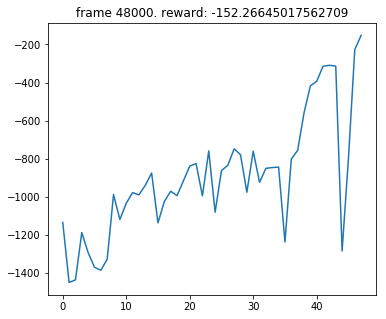

In [12]:
ob_shape = list(envs.observation_space.shape)
ac_shape = list(envs.action_space.shape)

ob = envs.reset()
early_stop = False

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
ppo = PPO(sess, ob_shape, ac_shape, lr, ppo_hidden_size)
discriminator = Discriminator(sess, ob_shape, ac_shape, discriminator_hidden_size, lr, 'D')

sess.run(tf.global_variables_initializer())


i_update = 0
state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:
    i_update += 1
    
    values    = []
    obs    = []
    acs   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):

        ac = ppo.get_action(ob)
        next_ob, _, done, _ = envs.step(ac)
        reward = discriminator.get_reward(np.concatenate([ob, ac], axis=1))
        
        value = ppo.get_value(ob)
        values.append(value)
        rewards.append(reward[:, np.newaxis])
        masks.append((1-done)[:, np.newaxis])

        obs.append(ob)
        acs.append(ac)

        ob = next_ob
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env(ppo) for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            

    next_value = ppo.get_value(next_ob)
    returns = compute_gae(next_value, rewards, masks, values)

    returns = np.concatenate(returns)
    values = np.concatenate(values)
    obs = np.concatenate(obs)
    acs = np.concatenate(acs)
    advantages = returns - values
    
    # Policy Update
    if i_update % 3 == 0:
        ppo.assign_old_pi()
        for _ in range(ppo_epochs):
            for ob_batch, ac_batch, return_batch, adv_batch in ppo_iter(mini_batch_size, obs, acs, returns, advantages):
                ppo.update(ob_batch, ac_batch, return_batch, adv_batch)
    
    # Discriminator Update
    expert_ob_ac = expert_traj[np.random.randint(0, expert_traj.shape[0], num_steps * num_envs), :]
    policy_ob_ac = np.concatenate([obs, acs], 1)
    discriminator.update(np.concatenate([expert_ob_ac, policy_ob_ac], axis=0))        